In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

# Set random seed
np.random.seed(0)

In [2]:
# Load the data
data = np.loadtxt('data.csv', delimiter=',')
print(data.shape)

# The columns are: 'curvature', 'displacement_x', 'displacement_y', 'target'
# where the target is an integer encoding the classes:
# ESTERNO = 0
# IN_MEZZO = 1
# INTERNO = 2
print('curvature, displacement_x, displacement_y, target')
print(data[0])

(6496, 4)
curvature, displacement_x, displacement_y, target
[0.04056095 0.         0.         2.        ]


In [3]:
# Split into train and test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)
print(train_data.shape)
print(test_data.shape)

# Normalize the train_data
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
train_df.columns = ['curvature', 'displacement_x', 'displacement_y', 'target']
test_df.columns = ['curvature', 'displacement_x', 'displacement_y', 'target']

scaler = StandardScaler()
scaler.fit(train_df[['curvature', 'displacement_x', 'displacement_y']])

train_df[['curvature', 'displacement_x', 'displacement_y']] = scaler.transform(train_df[['curvature', 'displacement_x', 'displacement_y']])
test_df[['curvature', 'displacement_x', 'displacement_y']] = scaler.transform(test_df[['curvature', 'displacement_x', 'displacement_y']])

(5196, 4)
(1300, 4)


# K-NN

In [28]:
train_X, train_y = train_df[['curvature', 'displacement_x', 'displacement_y']], train_df['target']
test_X, test_y = test_df[['curvature', 'displacement_x', 'displacement_y']], test_df['target']

# Convert to numpy arrays
train_X = np.array(train_X)
train_y = np.array(train_y)
test_X = np.array(test_X)
test_y = np.array(test_y)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5196, 3) (5196,) (1300, 3) (1300,)


In [31]:
# Perform a grid search for the best parameters of k-NN
params = {
    'n_neighbors': list(range(1, 20)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    #'leaf_size': list(range(1, 50)),
    'p': list(range(1, 10)),
    'n_jobs': [-1],
}
# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=0)
# Find the best parameters
clf = KNeighborsClassifier()
clf = GridSearchCV(clf, params, cv=kf, n_jobs=-1)
clf.fit(train_X, train_y)
print(clf.best_params_)

{'algorithm': 'ball_tree', 'n_jobs': -1, 'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}


In [32]:
# Retrain the model with the best parameters
clf = KNeighborsClassifier(**clf.best_params_)
clf.fit(train_X, train_y)
# Print the train and test classification report
print('Train report:')
print(classification_report(train_y, clf.predict(train_X)))
print('Test report:')
print(classification_report(test_y, clf.predict(test_X)))

Train report:
              precision    recall  f1-score   support

         0.0       0.61      0.52      0.56      1766
         1.0       0.53      0.10      0.16       722
         2.0       0.64      0.84      0.73      2708

    accuracy                           0.63      5196
   macro avg       0.59      0.49      0.48      5196
weighted avg       0.61      0.63      0.59      5196

Test report:
              precision    recall  f1-score   support

         0.0       0.49      0.42      0.45       432
         1.0       0.24      0.04      0.07       205
         2.0       0.58      0.79      0.67       663

    accuracy                           0.55      1300
   macro avg       0.43      0.41      0.40      1300
weighted avg       0.50      0.55      0.50      1300



# Random Forest

In [33]:
# Train a Random Forest model
from sklearn.ensemble import RandomForestClassifier

train_X, train_y = train_df[['curvature', 'displacement_x', 'displacement_y']], train_df['target']
test_X, test_y = test_df[['curvature', 'displacement_x', 'displacement_y']], test_df['target']

# Convert to numpy arrays
train_X = np.array(train_X)
train_y = np.array(train_y)
test_X = np.array(test_X)
test_y = np.array(test_y)

In [34]:
# Perform a grid search for the best parameters of Random Forest
params = {
    'n_estimators': [30],
    'max_depth': list(range(1, 10)),
    'min_samples_split': list(range(2, 5)),
    'min_samples_leaf': list(range(3, 5)),
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'n_jobs': [-1],
}
# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=0)
# Find the best parameters
clf = RandomForestClassifier()
clf = GridSearchCV(clf, params, cv=kf, n_jobs=-1)
clf.fit(train_X, train_y)
print(clf.best_params_)

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 30, 'n_jobs': -1}


In [35]:
# Retrain the model with the best parameters
clf = RandomForestClassifier(**clf.best_params_)
clf.fit(train_X, train_y)
# Print the train and test classification report
print('Train report:')
print(classification_report(train_y, clf.predict(train_X)))
print('Test report:')
print(classification_report(test_y, clf.predict(test_X)))

Train report:
              precision    recall  f1-score   support

         0.0       0.71      0.41      0.52      1766
         1.0       0.92      0.03      0.06       722
         2.0       0.62      0.94      0.74      2708

    accuracy                           0.64      5196
   macro avg       0.75      0.46      0.44      5196
weighted avg       0.69      0.64      0.57      5196

Test report:
              precision    recall  f1-score   support

         0.0       0.61      0.35      0.45       432
         1.0       0.40      0.01      0.02       205
         2.0       0.57      0.90      0.70       663

    accuracy                           0.58      1300
   macro avg       0.53      0.42      0.39      1300
weighted avg       0.56      0.58      0.51      1300



# NN

In [4]:
train, val = train_test_split(train_df, test_size=0.2, random_state=0)

train_X, train_y = train[['curvature', 'displacement_x', 'displacement_y']], train['target']
val_X, val_y = val[['curvature', 'displacement_x', 'displacement_y']], val['target']
test_X, test_y = test_df[['curvature', 'displacement_x', 'displacement_y']], test_df['target']

# Convert to numpy arrays
train_X = np.array(train_X)
train_y = np.array(train_y)
val_X = np.array(val_X)
val_y = np.array(val_y)
test_X = np.array(test_X)
test_y = np.array(test_y)

# Encode the targets to one-hot vectors
train_y = to_categorical(train_y)
val_y = to_categorical(val_y)
test_y = to_categorical(test_y)

print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(4156, 3) (4156, 3) (1040, 3) (1040, 3) (1300, 3) (1300, 3)


In [50]:
model = Sequential()
model.add(Dense(128, input_dim=3))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Dense(128))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               512       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 activation_1 (Activation)   (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 128)              

2022-01-12 11:17:02.516612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-12 11:17:02.983927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - 1s 6ms/step - loss: 0.8002 - accuracy: 0.6268
Train accuracy: 0.6268045902252197
33/33 [==============================] - 0s 7ms/step - loss: 0.9104 - accuracy: 0.5798
Val accuracy: 0.579807698726654


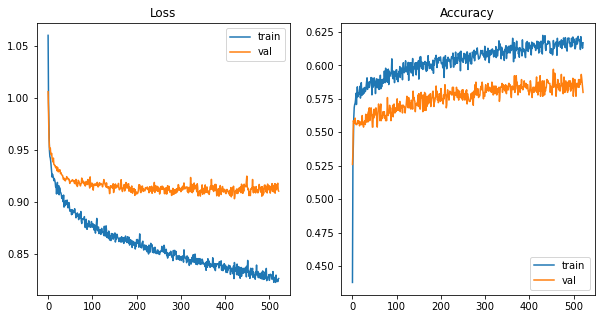

In [51]:
history = model.fit(
    train_X, train_y, epochs=1000, batch_size=256,
    validation_data=(val_X, val_y), callbacks=[EarlyStopping(monitor='val_loss', patience=100)], verbose=0
)
# Print train and val accuracy
print('Train accuracy:', model.evaluate(train_X, train_y)[1])
print('Val accuracy:', model.evaluate(val_X, val_y)[1])
# Plot the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.title('Accuracy')
plt.show()

In [7]:
# Print the train and test classification report
print('Train report:')
def one_hot_to_label(y):
    return np.argmax(y, axis=1)
print('Train report:')
print(classification_report(one_hot_to_label(train_y), one_hot_to_label(model.predict(train_X))))
print('Test report:')
print(classification_report(one_hot_to_label(test_y), one_hot_to_label(model.predict(test_X))))

Train report:
Train report:


2022-01-15 00:10:32.726563: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-15 00:10:32.775729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.64      0.47      0.54      1430
           1       0.20      0.00      0.00       565
           2       0.62      0.89      0.73      2161

    accuracy                           0.63      4156
   macro avg       0.49      0.46      0.43      4156
weighted avg       0.57      0.63      0.57      4156

Test report:
              precision    recall  f1-score   support

           0       0.55      0.37      0.44       432
           1       0.50      0.01      0.02       205
           2       0.58      0.88      0.70       663

    accuracy                           0.57      1300
   macro avg       0.54      0.42      0.39      1300
weighted avg       0.56      0.57      0.51      1300



In [63]:
# Save the model
model.save('model.h5')

In [6]:
# Load the model
model = load_model('model.h5')

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-01-15 00:10:30.664214: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-15 00:10:30.666002: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Initial cones:  18 18
Removing duplicates (equal cones):  18 18
Car position:  (105, 0)
Car direction:  (0, 1)
Remove noise cones: 18 18


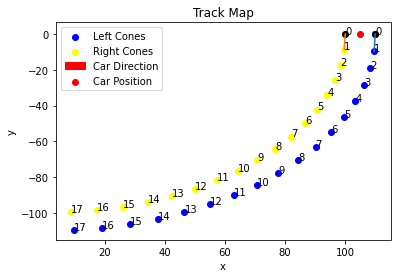

Reorder cones:  18 18


In [11]:
# Test the model on a Sample Track Map
from TrackMap import TrackMap
from Trajectory import Trajectory
from GraphicUtility import plot_trajectory, plot_track_map, end_plotting
from SampleTrack import StraightTrackMap, CircleTrackMap
from Parameters import Parameters
from Utils import euclidean_distance, find_closest_point, compute_middle_point, compute_spline, find_line
from PlanStep import PlanStep

#track_map = StraightTrackMap(100, 10, 20, 0, 0)
track_map = CircleTrackMap(100, 10, 20, 0, 0, 0, -90, False)

time: 14.87975782467691
Middle trajectory:


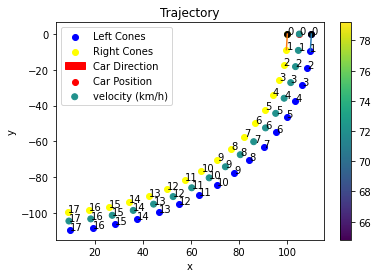

Opt. trajectory time: 61.501368931415854
Optimal trajectory:


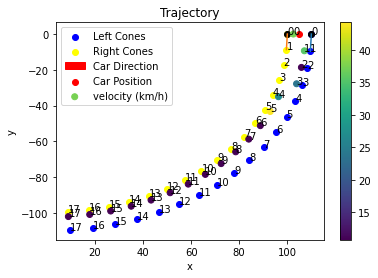

In [12]:
parameters = Parameters()
trajectory = Trajectory(parameters)

trajectory.compute_middle_trajectory(track_map)
trajectory.compute_velocities()
print('time:', trajectory.compute_time())

print('Middle trajectory:')
plot_track_map(track_map)
plot_trajectory(trajectory.get_trajectory(), new_figure=False)
end_plotting()

curvatures = list(map(lambda x: x.curvature, trajectory.get_trajectory()))
displacemets = [(0,0)] + list(map(lambda x1, x2: (x2.position[0] - x1.position[0], x2.position[1] - x1.position[1]) , trajectory.get_trajectory()[:-1], trajectory.get_trajectory()[1:]))

sample = pd.DataFrame({'curvature': curvatures, 'displacement_x': [x[0] for x in displacemets], 'displacement_y': [x[1] for x in displacemets]})
# Rescale the data
sample_scaled = scaler.transform(sample)

# Predict the target
prediction = model.predict(sample_scaled)

prediction = one_hot_to_label(prediction)
new_trajectory = []

for i, step in enumerate(trajectory.get_trajectory()):
    nearest_left_cone = track_map.get_left_cones()[find_closest_point(step.position, track_map.get_left_cones())]
    nearest_right_cone = track_map.get_right_cones()[find_closest_point(step.position, track_map.get_right_cones())]
    left = PlanStep(compute_middle_point(step.position, nearest_left_cone))
    right = PlanStep(compute_middle_point(step.position, nearest_right_cone))
    if prediction[i] == 0:
        new_step = left
    elif prediction[i] == 1:
        new_step = step
    elif prediction[i] == 2:
        new_step = right
    new_trajectory.append(new_step)

trajectory.set_trajectory(new_trajectory)
trajectory.compute_velocities()
print('Opt. trajectory time:', trajectory.compute_time())
print('Optimal trajectory:')
plot_track_map(track_map)
plot_trajectory(trajectory.get_trajectory(), new_figure=False)
end_plotting()